## Xgboost train,testset에서 Class 1중 확률이 0.3~0.6인 sample extraction

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


## 0.3~0.6 modeling

In [141]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [142]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

In [143]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [144]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              802811
1              194558
Name: count, dtype: int64
Original data size: 1488611 samples
Undersampled data size: 389116 samples

Undersampling imbalance check
loan_status
0    194558
1    194558
Name: count, dtype: int64


In [145]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

In [147]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

[0]	validation_0-logloss:0.68687	validation_1-logloss:0.68689
[1]	validation_0-logloss:0.68072	validation_1-logloss:0.68076
[2]	validation_0-logloss:0.67468	validation_1-logloss:0.67475
[3]	validation_0-logloss:0.66877	validation_1-logloss:0.66886
[4]	validation_0-logloss:0.66297	validation_1-logloss:0.66309
[5]	validation_0-logloss:0.65728	validation_1-logloss:0.65743
[6]	validation_0-logloss:0.65170	validation_1-logloss:0.65188
[7]	validation_0-logloss:0.64622	validation_1-logloss:0.64644
[8]	validation_0-logloss:0.64084	validation_1-logloss:0.64110
[9]	validation_0-logloss:0.63557	validation_1-logloss:0.63587
[10]	validation_0-logloss:0.63040	validation_1-logloss:0.63073
[11]	validation_0-logloss:0.62531	validation_1-logloss:0.62569
[12]	validation_0-logloss:0.62033	validation_1-logloss:0.62075
[13]	validation_0-logloss:0.61543	validation_1-logloss:0.61590
[14]	validation_0-logloss:0.61062	validation_1-logloss:0.61113
[15]	validation_0-logloss:0.60590	validation_1-logloss:0.60646
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [148]:
# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

X_test_df = X_test.copy()
X_test_df['y_prob'] = y_prob
X_test_df['y_pred'] = y_pred
X_test_df['actual'] = y_test.values

filtered = X_test_df[(X_test_df['actual'] == 1)&
                     (X_test_df['y_prob']>=0.3)&
                     (X_test_df['y_prob']<=0.6)]

filtered2 = X_test_df[(X_test_df['actual'] == 0)&
                      (X_test_df['y_pred'] == 1)&
                      (X_test_df['y_prob']>=0.5)]


print(f"⚠️ 조건에 맞는 샘플 개수 filtered 1: {len(filtered)}")
print(f"⚠️ 조건에 맞는 샘플 개수 filtered 2: {len(filtered2)}")
#display(filtered.head())  # Jupyter 환경이면 이렇게

⚠️ 조건에 맞는 샘플 개수 filtered 1: 4588
⚠️ 조건에 맞는 샘플 개수 filtered 2: 41063


In [18]:
test_data['loan_status'].value_counts()

loan_status
0    299557
1     72596
Name: count, dtype: int64

In [28]:
filtered.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,revol_util,revol_bal,total_acc,credit_history_years,y_prob,y_pred,actual
20,579.0,112.0,0.1153,38000.0,26.34,846.0,277.12,660.0,9000.0,5176.0,1801.000000,0.635,5713.0,10.0,10,0.463981,0,1
31,584.0,39.0,0.1824,50300.0,20.07,24.0,590.25,720.0,5900.0,6294.0,11065.920936,0.201,1184.0,12.0,3,0.452710,0,1
107,559.0,122.0,0.1399,56000.0,27.93,483.0,239.21,665.0,3000.0,2336.0,0.000000,0.970,3008.0,31.0,11,0.502033,1,1
168,664.0,183.0,0.1311,76000.0,25.69,113.0,547.43,735.0,125600.0,7591.0,33170.000000,0.602,75614.0,19.0,16,0.435260,0,1
212,629.0,249.0,0.1333,245000.0,13.59,891.0,802.29,680.0,57100.0,40926.0,1976.000000,0.806,46024.0,28.0,21,0.401548,0,1


In [37]:
drop_columns = ['y_prob', 'y_pred', 'actual']
filtered = filtered.drop(columns=drop_columns)

In [38]:
filtered['loan_status'] = 1

In [39]:
path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
filtered.to_csv(path_or_buf=path+"filtered_class1_0.3to0.6.csv", index=False)

## undersampling 적용

In [72]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [73]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

In [74]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [75]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              802811
1              194558
Name: count, dtype: int64
Original data size: 1488611 samples
Undersampled data size: 389116 samples

Undersampling imbalance check
loan_status
0    194558
1    194558
Name: count, dtype: int64


In [76]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68687	validation_1-logloss:0.68689
[1]	validation_0-logloss:0.68072	validation_1-logloss:0.68076
[2]	validation_0-logloss:0.67468	validation_1-logloss:0.67475
[3]	validation_0-logloss:0.66877	validation_1-logloss:0.66886
[4]	validation_0-logloss:0.66297	validation_1-logloss:0.66309
[5]	validation_0-logloss:0.65728	validation_1-logloss:0.65743
[6]	validation_0-logloss:0.65170	validation_1-logloss:0.65188
[7]	validation_0-logloss:0.64622	validation_1-logloss:0.64644
[8]	validation_0-logloss:0.64084	validation_1-logloss:0.64110
[9]	validation_0-logloss:0.63557	validation_1-logloss:0.63587
[10]	validation_0-logloss:0.63040	validation_1-logloss:0.63073
[11]	validation_0-logloss:0.62531	validation_1-logloss:0.62569
[12]	validation_0-logloss:0.62033	validation_1-logloss:0.62075
[13]	validation_0-logloss:0.61543	validation_1-logloss:0.61590
[14]	validation_0-logloss:0.61062	validation_1-logloss:0.61113
[15]	validation_0-logloss:0.60590	validation_1-logloss:0.60646
[1

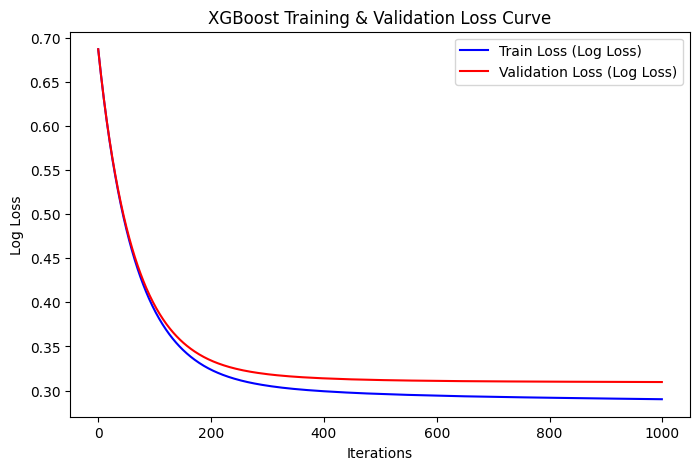

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.92    299557
           1       0.62      0.91      0.73     72596

    accuracy                           0.87    372153
   macro avg       0.79      0.88      0.82    372153
weighted avg       0.90      0.87      0.88    372153



In [78]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

## Dataset을 줄여보자
- 전체 데이터셋에서 만들어진 90만 개 데이터 중에서 30만개
- 0.3~0.6으로 만들어진 데이터 20만개 
- class 0는 undersampling 적용

In [141]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [210]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

In [221]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 332759 samples (22.4%)
Validation size: 163897 samples (11.0%)
Test size: 372153 samples (25.0%)


In [222]:
y_train.value_counts()

loan_status
1              194558
0              138201
Name: count, dtype: int64

In [157]:
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

In [8]:
##fake 데이터 50만개로 줄이기
fake_50K = fake.sample(n = 400000, random_state=42).reset_index(drop=True)

In [172]:
len(fake)

900000

In [198]:
"""X_fake = fake_50K.drop(columns='loan_status')
y_fake = fake_50K[['loan_status']]"""

X_fake = fake.drop(columns='loan_status')
y_fake = fake[['loan_status']]

In [199]:
# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_fake)
y_prob = model.predict_proba(X_fake)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

X_fake_df = X_fake.copy()
X_fake_df['y_prob'] = y_prob
X_fake_df['y_pred'] = y_pred
X_fake_df['actual'] = y_fake.values

#0.5이상인 것들 확인인
filtered_fake = X_fake_df[(X_fake_df['actual'] == 1)&
                     (X_fake_df['y_prob']>=0)&
                     (X_fake_df['y_prob']<=0.93)]

print(f"⚠️ 조건에 맞는 샘플 개수: {len(filtered_fake)}")
display(filtered_fake.head())  # Jupyter 환경이면 이렇게

⚠️ 조건에 맞는 샘플 개수: 506257


,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,revol_util,revol_bal,total_acc,credit_history_years,y_prob,y_pred,actual
5,564.0,244.0,0.1565,99337.0,12.48,672.0,411.42,675.0,10079.0,20780.0,1255.0,0.558,5985.0,17.0,20.0,0.874683,1,1
7,544.0,152.0,0.1209,198248.0,24.81,338.0,621.19,680.0,28845.0,5208.0,2620.0,0.662,15150.0,21.0,14.0,0.922788,1,1
8,609.0,385.0,0.1392,139375.0,28.96,680.0,961.86,700.0,32170.0,6779.0,2272.0,0.578,18205.0,36.0,32.0,0.867636,1,1
9,499.0,192.0,0.0962,198000.0,19.84,890.0,335.00,670.0,18795.0,42355.0,1894.0,0.731,13462.0,28.0,15.0,0.908951,1,1
12,539.0,88.0,0.1343,93363.0,21.78,216.0,328.28,695.0,28130.0,4623.0,1884.0,0.768,14562.0,32.0,11.0,0.905865,1,1


In [200]:
drop_columns = ['y_prob', 'y_pred', 'actual']
filtered_fake = filtered_fake.drop(columns=drop_columns)

filtered_fake['loan_status'] = 1

In [201]:
fake_path2 = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/filter/filter_OI_11_00_fake.csv"
fake2 = pd.read_csv(fake_path2)
fake2['loan_status'] = 1

In [24]:
len(fake2)

500000

In [202]:
fake2_20K = fake2.sample(n = 100000, random_state=42).reset_index(drop=True)

In [57]:
"""X_fake2 = fake2.drop(columns='loan_status')
y_fake2 = fake2[['loan_status']]"""

"""# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_fake)
y_prob = model.predict_proba(X_fake2)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

X_fake_df2 = X_fake2.copy()
X_fake_df2['y_prob'] = y_prob
X_fake_df2['y_pred'] = y_pred
X_fake_df2['actual'] = y_fake2.values

#0.5이상인 것들 확인인
filtered2 = X_fake_df2[(X_fake_df2['actual'] == 1)&
                     (X_fake_df2['y_prob']>=0.5)]

print(f"⚠️ 조건에 맞는 샘플 개수: {len(filtered2)}")
display(filtered2.head())  # Jupyter 환경이면 이렇게"""

'# 5️⃣ 예측 및 평가\n#y_pred = model.predict(X_fake)\ny_prob = model.predict_proba(X_fake2)[:, 1]  # ROC Curve & PRC에 필요\n\nthreshold = 0.5\ny_pred = (y_prob >= threshold).astype(int)\n\nX_fake_df2 = X_fake2.copy()\nX_fake_df2[\'y_prob\'] = y_prob\nX_fake_df2[\'y_pred\'] = y_pred\nX_fake_df2[\'actual\'] = y_fake2.values\n\n#0.5이상인 것들 확인인\nfiltered2 = X_fake_df2[(X_fake_df2[\'actual\'] == 1)&\n                     (X_fake_df2[\'y_prob\']>=0.5)]\n\nprint(f"⚠️ 조건에 맞는 샘플 개수: {len(filtered2)}")\ndisplay(filtered2.head())  # Jupyter 환경이면 이렇게'

In [203]:
from sklearn.utils import shuffle

fake_total = pd.concat([filtered_fake, fake2_20K])
train_dataset = pd.concat([X_train, y_train], axis=1)

train_total = pd.concat([train_dataset,fake_total])
train_total = shuffle(train_total, random_state=42)

In [29]:
fake2['loan_status'].value_counts()

loan_status
1    500000
Name: count, dtype: int64

In [204]:
train_total['loan_status'].value_counts()

loan_status
0    802811
1    800815
Name: count, dtype: int64

In [205]:
X_train = train_total.drop(columns='loan_status')
y_train = train_total[['loan_status']]

In [192]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              802811
1              700815
Name: count, dtype: int64
Original data size: 1488611 samples
Undersampled data size: 1401630 samples

Undersampling imbalance check
loan_status
0    700815
1    700815
Name: count, dtype: int64


In [193]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model2 = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.67333	validation_1-logloss:0.67332
[1]	validation_0-logloss:0.66804	validation_1-logloss:0.66803
[2]	validation_0-logloss:0.66284	validation_1-logloss:0.66282
[3]	validation_0-logloss:0.65774	validation_1-logloss:0.65771
[4]	validation_0-logloss:0.65276	validation_1-logloss:0.65272
[5]	validation_0-logloss:0.64785	validation_1-logloss:0.64781
[6]	validation_0-logloss:0.64304	validation_1-logloss:0.64299
[7]	validation_0-logloss:0.63833	validation_1-logloss:0.63827
[8]	validation_0-logloss:0.63369	validation_1-logloss:0.63363
[9]	validation_0-logloss:0.62915	validation_1-logloss:0.62908
[10]	validation_0-logloss:0.62469	validation_1-logloss:0.62462
[11]	validation_0-logloss:0.62031	validation_1-logloss:0.62022
[12]	validation_0-logloss:0.61601	validation_1-logloss:0.61592
[13]	validation_0-logloss:0.61179	validation_1-logloss:0.61169
[14]	validation_0-logloss:0.60764	validation_1-logloss:0.60753
[15]	validation_0-logloss:0.60357	validation_1-logloss:0.60346
[1

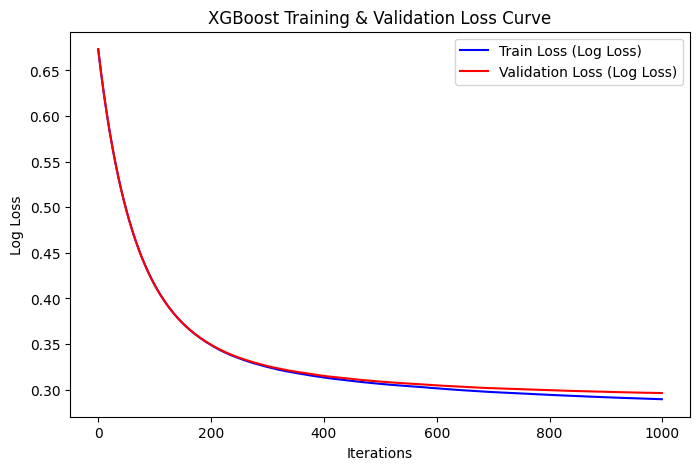

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.26      0.40    299557
           1       0.21      0.83      0.34     72596

    accuracy                           0.37    372153
   macro avg       0.54      0.54      0.37    372153
weighted avg       0.73      0.37      0.38    372153



In [224]:
model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model2.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model2.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [98]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[267997  31560]
 [ 12153  60443]]

True Positives (TP): 60443
False Positives (FP): 31560
True Negatives (TN): 267997
False Negatives (FN): 12153


## 0.3~0.6과 원래의 fake 데이터셋 분석

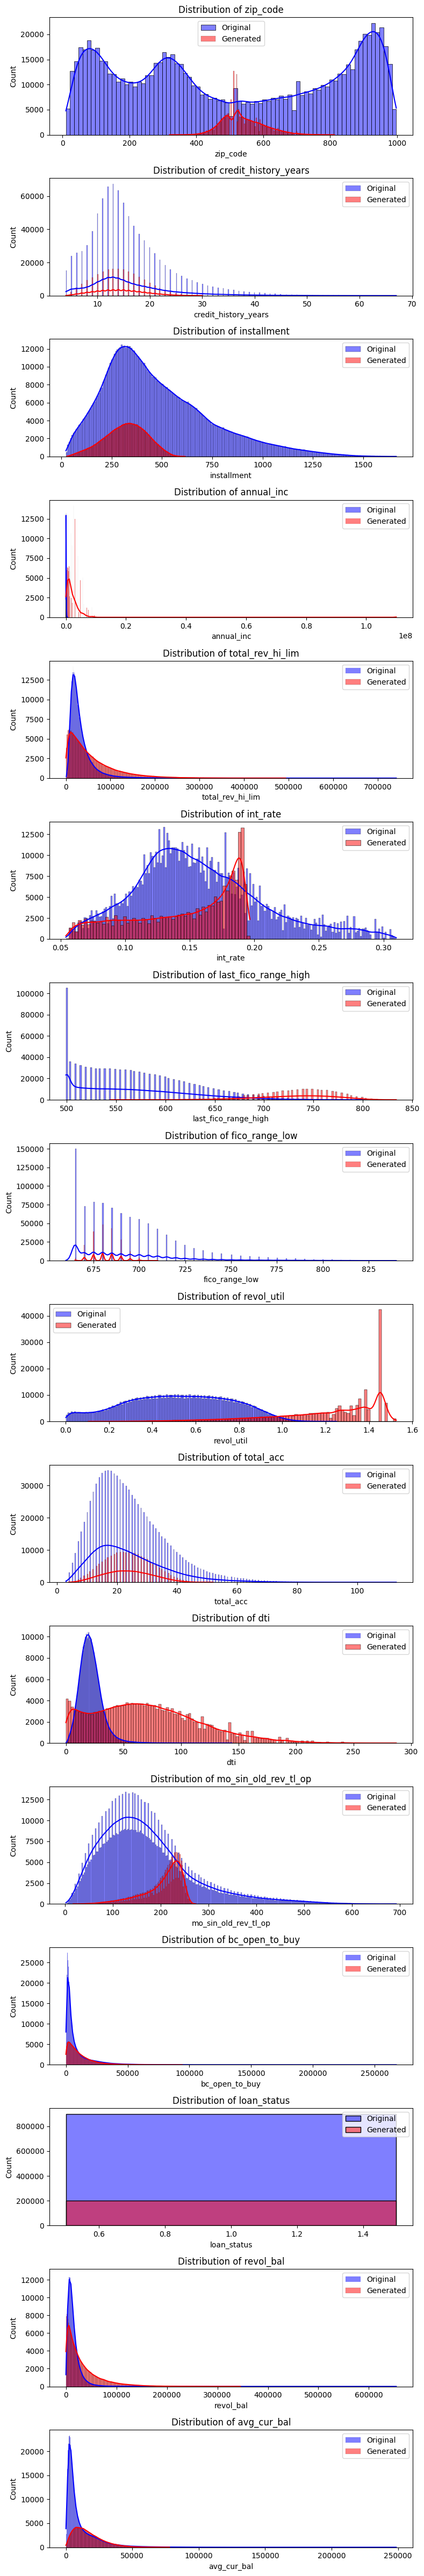

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(fake.columns) & set(fake2.columns))
original_df = fake[common_features]
generated_df = fake2[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()